In [1]:
# Univariate Time Series Regression using Transformers on Bitcoin Close Price Data
# Short term close bitcoin price prediction using Transformers 

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import losses
from tensorflow.keras.constraints import MaxNorm as maxnorm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
#sound_file = 'beep.wav'
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import PowerTransformer

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os
from matplotlib import pyplot

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

/root/.pyenv/versions/3.7.9/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/root/.pyenv/versions/3.7.9/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/root/.pyenv/versions/3.7.9/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# Time 2 Vec Custom Layer for Tensorflow 2

class Time2Vec(Layer):
    
    def __init__(self, dim=None, **kwargs):
        self.dim = dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.Wei = self.add_weight(name='Wei',
                                shape=(input_shape[-1], self.dim),
                                initializer='uniform',
                                trainable=True)

        self.Para = self.add_weight(name='Para',
                                shape=(input_shape[1], self.dim),
                                initializer='uniform',
                                trainable=True)

        self.wei = self.add_weight(name='wei',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.para = self.add_weight(name='para',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        initial = self.wei * x + self.para
        sine_transformation = K.sin(K.dot(x, self.Wei) + self.Para)
        
        return K.concatenate([sine_transformation, initial], -1)


In [4]:
# Dataset - FREE HISTORICAL DATA from https://www.cryptodatadownload.com/data/

# Data is organized by exchange and symbol. Please select the exchange grouping below. This data is offered for free under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License

dataframe = pd.read_csv("../data/new/gemini_BTCUSD_1hr.csv", sep=',', skiprows=1, 
                        parse_dates=True, squeeze=True, header=0, index_col=1)


In [5]:
dataframe.head(3)

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2021-08-17 00:00:00,1629158400000,BTCUSD,45911.98,46092.77,45855.18,45869.40,8.181504
2021-08-16 23:00:00,1629154800000,BTCUSD,46122.00,46200.48,45729.02,45911.98,64.325364
2021-08-16 22:00:00,1629151200000,BTCUSD,46072.69,46352.96,46006.06,46122.00,45.393337


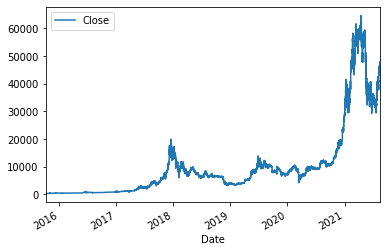

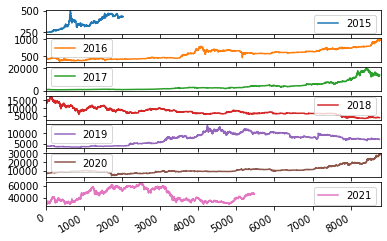

In [6]:
# Data Visualization
import warnings
warnings.filterwarnings('ignore')

# Price Data variation by year
series = dataframe[['Close']]
series.plot()
pyplot.show()

# Price Data variation by hours in a year 24*365=8760
years_ls = []
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    series_temp = pd.DataFrame()
    series_temp[name.year] = group.values.ravel()
    years_ls.append(name.year)
    years = pd.concat([years,series_temp], ignore_index=True, axis=1)
years.columns = years_ls
years.plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()


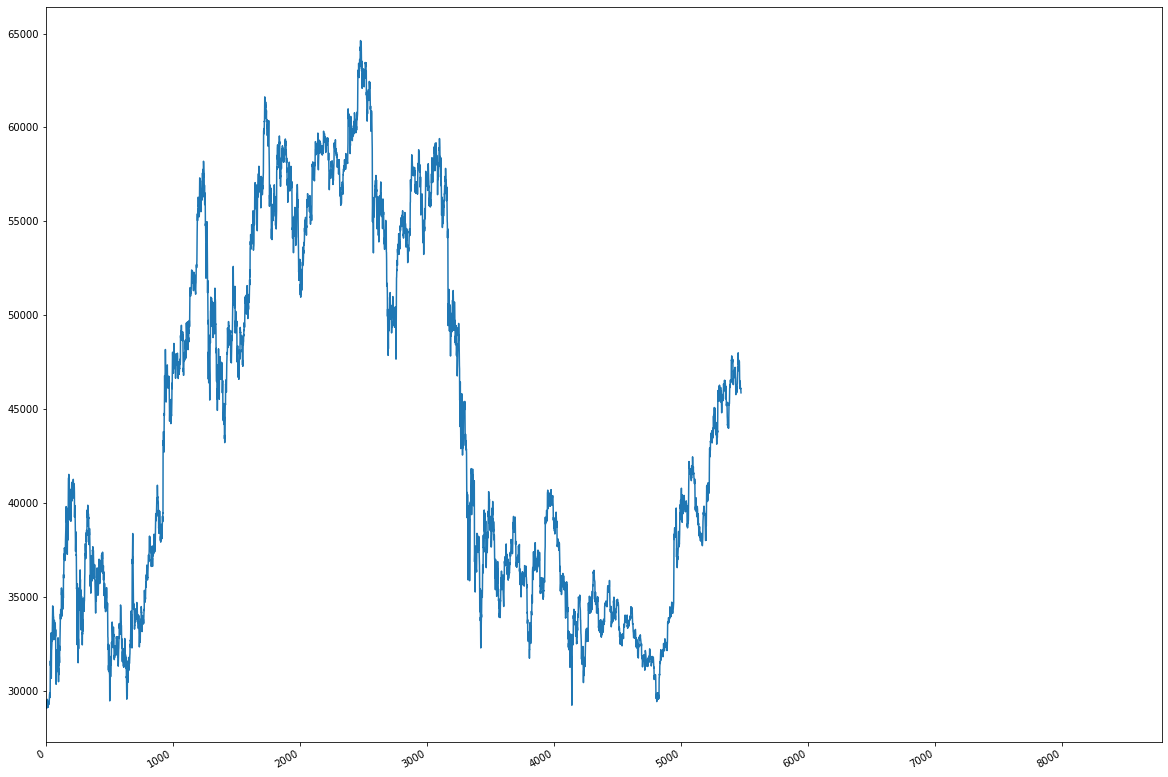

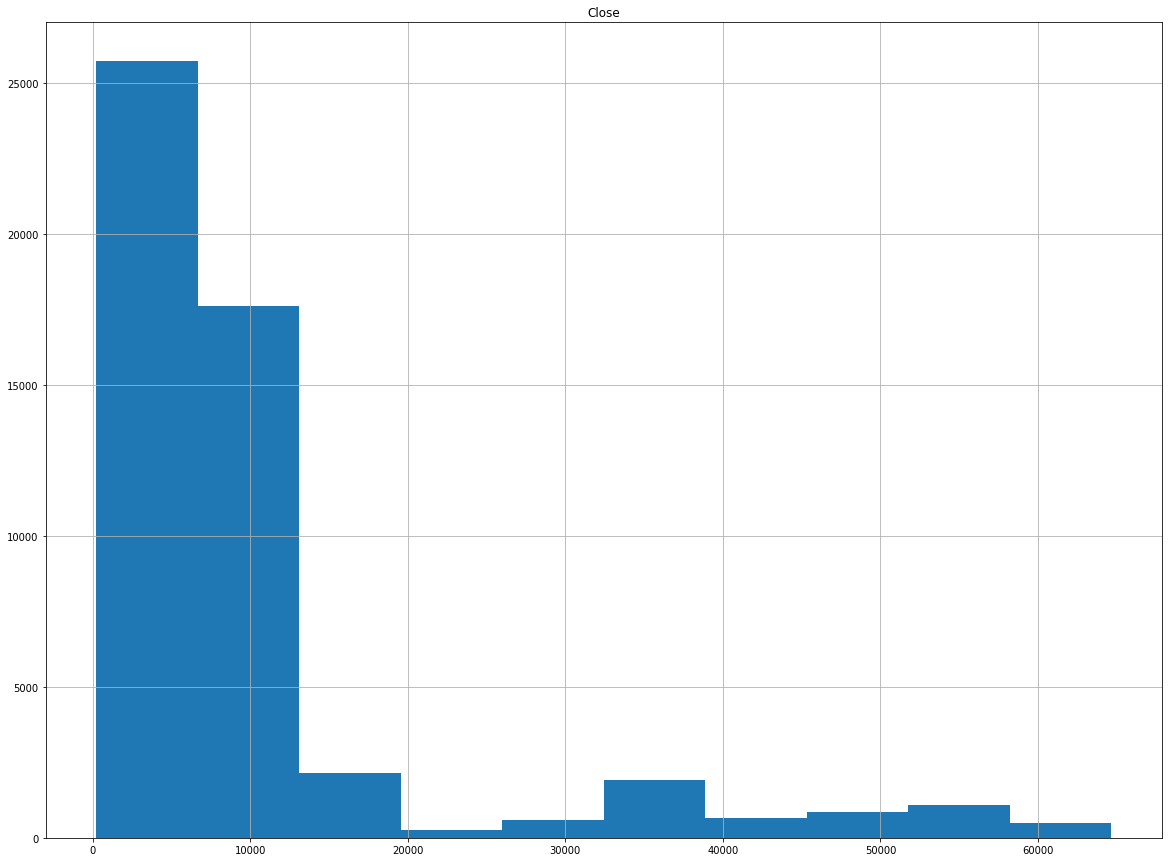

In [7]:
# 2021 Changes
years[2021].plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()


# Histogram of price distribution - as we can see looks highly skewed
series.hist()
pyplot.show()

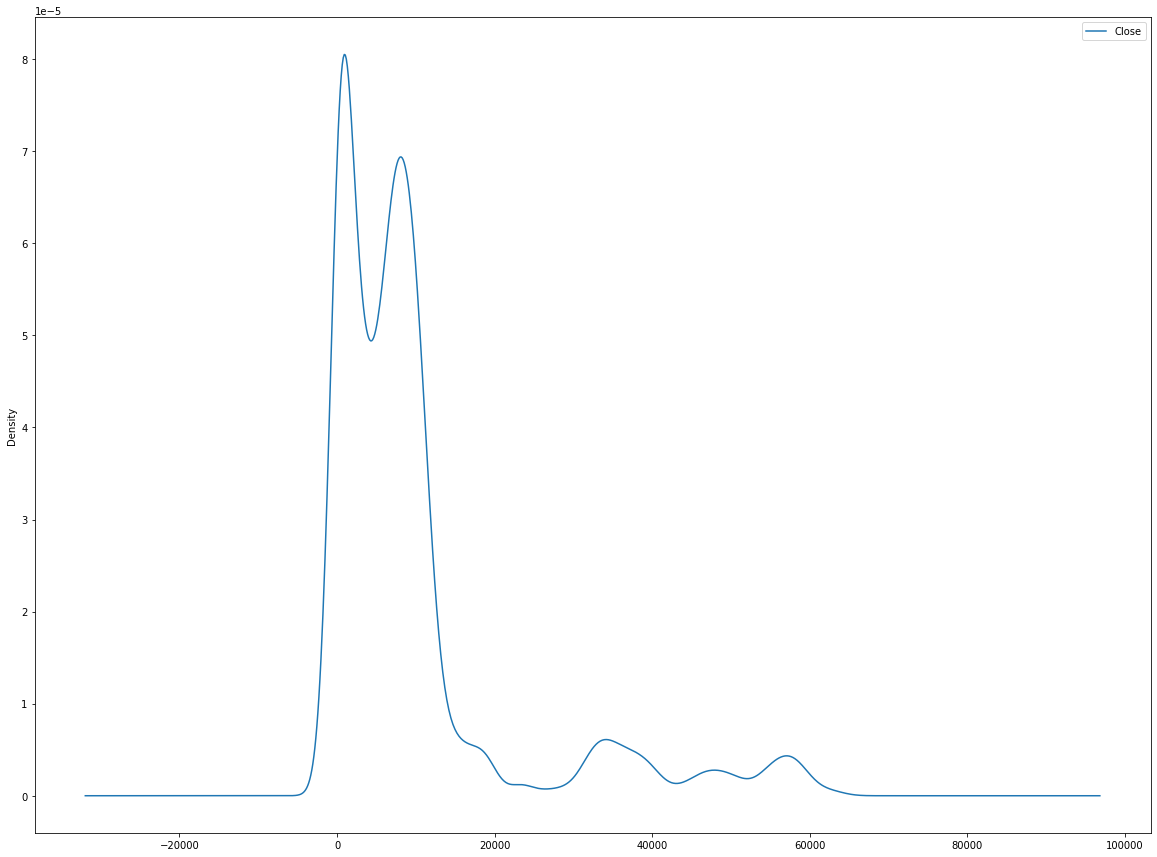

In [8]:
# Density Plot to see the distribution
series.plot(kind='kde')
pyplot.show()

In [9]:
# Scaling using Power transform and spliting the dataset
dataframe = pd.read_csv("../data/new/gemini_BTCUSD_1hr.csv", sep=',', skiprows=1, 
                        parse_dates=True, squeeze=True, header=0, index_col=1)
dataframe
#dataset = dataframe#[pd.to_datetime(dataframe['Date']) > pd.to_datetime('2017-01-01 00:00:00')]

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2021-08-17 00:00:00,1629158400000,BTCUSD,45911.98,46092.77,45855.18,45869.40,8.181504
2021-08-16 23:00:00,1629154800000,BTCUSD,46122.00,46200.48,45729.02,45911.98,64.325364
2021-08-16 22:00:00,1629151200000,BTCUSD,46072.69,46352.96,46006.06,46122.00,45.393337
2021-08-16 21:00:00,1629147600000,BTCUSD,46069.96,46249.99,45903.58,46072.69,42.772270
2021-08-16 20:00:00,1629144000000,BTCUSD,46087.02,46128.05,45661.78,46069.96,118.073849
...,...,...,...,...,...,...,...
2015-10-08 17:00:00,1444323600,BTCUSD,244.25,244.99,244.02,244.99,3.920632
2015-10-08 16:00:00,1444320000,BTCUSD,244.92,244.92,244.25,244.25,3.895252
2015-10-08 15:00:00,1444316400,BTCUSD,245.00,245.00,244.92,244.92,3.016926


In [26]:
# Preprocessing Steps

dataset = dataframe#[pd.to_datetime(dataframe['Date']) > pd.to_datetime('2017-01-01 00:00:00')]

# As we can see in the density plots, the data is high skewed, 
# so we are going to do a median based replacement on IOR quantitle score 
# for values of std deviation less than 25% and more than 75% 

# length=dataset.shape[1]

# for i in dataset.columns:
#     try:
#         dataset[i] = np.where(dataset[i] > dataframe[i].quantile(0.75), dataframe[i].quantile(0.50), dataframe[i])
#         #dataset[i] = np.where(dataset[i] < dataframe[i].quantile(0.25), dataframe[i].quantile(0.50), dataframe[i])
#     except:
#         pass

# Transform
dataset = dataset[['Close']].values.astype('float32')
pw_transform = PowerTransformer()
dataset = pw_transform.fit_transform(dataset)

# Spliting the dataset
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# Creating dataset with timesteps
def create_dataset_with_timesteps(dataset, timesteps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-timesteps-1):
        a = dataset[i:(i+timesteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + timesteps, 0])

    return np.array(dataX), np.array(dataY)

# Creating dataset for 10 timesteps
timesteps = 10
X_train, y_train = create_dataset_with_timesteps(train, timesteps)
X_test, y_test = create_dataset_with_timesteps(test, timesteps)

# Removing Outliers

# #A lot of local outliers due to variance over time will affect convergence removing 
# from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

# reshape input to be [samples, time steps, features] for time2vec
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

35941 15404


In [27]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [28]:
# Model Arch - Time2VEC-LSTM-Dense, Loss: MAE, Opt: Adam
model = Sequential()
model.add(Time2Vec(4))
model.add(LSTM(4, input_shape=(1, timesteps), activation='relu', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_split=0.1)
model.evaluate(X_test, y_test, batch_size=64)

Train on 29103 samples, validate on 3234 samples
Epoch 1/20
29103/29103 - 16s - loss: 0.1561 - val_loss: 0.0439
Epoch 2/20
29103/29103 - 14s - loss: 0.0619 - val_loss: 0.0296
Epoch 3/20
29103/29103 - 14s - loss: 0.0532 - val_loss: 0.0136
Epoch 4/20
29103/29103 - 10s - loss: 0.0473 - val_loss: 0.0131
Epoch 5/20
29103/29103 - 12s - loss: 0.0427 - val_loss: 0.0221
Epoch 6/20
29103/29103 - 11s - loss: 0.0378 - val_loss: 0.0170
Epoch 7/20
29103/29103 - 13s - loss: 0.0339 - val_loss: 0.0192
Epoch 8/20
29103/29103 - 15s - loss: 0.0315 - val_loss: 0.0211
Epoch 9/20
29103/29103 - 13s - loss: 0.0295 - val_loss: 0.0210
Epoch 10/20
29103/29103 - 14s - loss: 0.0282 - val_loss: 0.0249
Epoch 11/20
29103/29103 - 15s - loss: 0.0263 - val_loss: 0.0225
Epoch 12/20
29103/29103 - 15s - loss: 0.0251 - val_loss: 0.0251
Epoch 13/20
29103/29103 - 14s - loss: 0.0241 - val_loss: 0.0258
Epoch 14/20
29103/29103 - 16s - loss: 0.0234 - val_loss: 0.0255
Epoch 15/20
29103/29103 - 16s - loss: 0.0234 - val_loss: 0.0270


0.47311165090123947

In [29]:
import math

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = pw_transform.inverse_transform(trainPredict)
y_train = pw_transform.inverse_transform(y_train.reshape(-1, 1))
testPredict = pw_transform.inverse_transform(testPredict)
y_test = pw_transform.inverse_transform(y_test.reshape(-1, 1))

#trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(y_test, testPredict))
#print('Test Score: %.2f RMSE' % (testScore))

mae=mean_absolute_error(y_test, testPredict) #mae

r2=r2_score(y_test, testPredict) #testing score/ r^2
print('Test Score: MAE: {} R^2: {}'.format(mae, r2))

Test Score: MAE: 321.359375 R^2: 0.6831277672042693


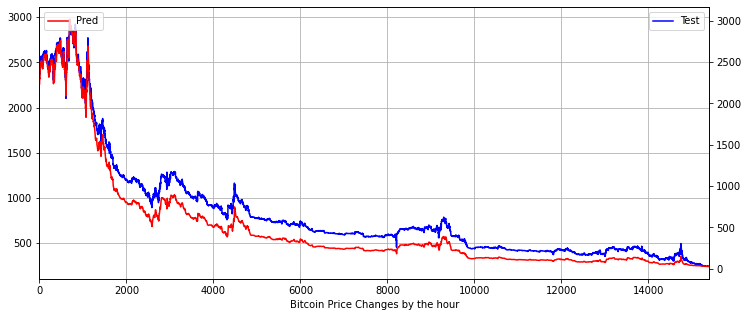

In [30]:

df_test = pd.DataFrame(columns=["Test", "Pred"])
df_test["Test"] = y_test.ravel()
df_test["Pred"] = testPredict.ravel()

plt.figure(figsize=(12,5))
plt.xlabel('Bitcoin Price Changes by the hour')

ax1 = df_test.Test.plot(color='blue', grid=True, label='Test')
ax2 = df_test.Pred.plot(color='red', grid=True, secondary_y=True, label='Pred')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

In [31]:
# mae=mean_absolute_error(y_test, testPredict) #mae

# r2=r2_score(y_test, testPredict) #testing score/ r^2
# print('Test Score: MAE: {} R^2: {}'.format(mae, r2))